# Project 2 : Reacher (Continuous Control)

## Prepare the environment

If necessary, uncomment and execute the following commands to install the Python requirements for this project

In [ ]:
#!pip -q install ../python
!pip install --no-deps unityagents

Load the Unity environment. Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [1]:
from unityagents import UnityEnvironment
import numpy as np

# Load a single agent of the environment
env = UnityEnvironment(file_name='Reacher_Linux_NoVis/Reacher.x86_64')

# Get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [2]:
# Imports
import random
import torch
import numpy as np
from collections import deque
import time
import matplotlib.pyplot as plt

# Set plotting options
%matplotlib inline
plt.style.use('ggplot')
np.set_printoptions(precision=3, linewidth=120)

# Hide Matplotlib deprecate warnings
import warnings
warnings.filterwarnings("ignore")

# High resolution plot outputs for retina display
%config InlineBackend.figure_format = 'retina'

## Check the Unity environment

In [3]:
# Reset the environment    
env_info = env.reset(train_mode=True)[brain_name]     

# number of agents
num_agents = len(env_info.agents)

# size of each action
ENV_ACTION_SIZE = brain.vector_action_space_size

# size of the state space 
states = env_info.vector_observations
ENV_STATE_SIZE = states.shape[1]

print('There are {} agents. Each observes a state with length: {} and act within an action space of length: {}'.format(states.shape[0], 
                                                                                                                       ENV_STATE_SIZE, 
                                                                                                                       ENV_ACTION_SIZE))

There are 1 agents. Each observes a state with length: 33 and act within an action space of length: 4


### Train the Agent with DDPG

Define a training function 

In [4]:
from ddpg_agent import Agent

# Agent default hyperparameters
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 128        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-4         # learning rate of the actor 
LR_CRITIC = 1e-3        # learning rate of the critic
WEIGHT_DECAY = 0        # L2 weight decay
ACTOR_FC1_UNITS = 400   # Number of units for the layer 1 in the actor model
ACTOR_FC2_UNITS = 300   # Number of units for the layer 2 in the actor model
CRITIC_FCS1_UNITS = 400 # Number of units for the layer 1 in the critic model
CRITIC_FC2_UNITS = 300  # Number of units for the layer 2 in the critic model
BN_MODE = 0             # Use Batch Norm. - 0=disabled, 1=BN before Activation, 2=BN after Activation (3, 4 are alt. versions of 1, 2)
ADD_OU_NOISE = True     # Add Ornstein-Uhlenbeck noise
MU = 0.                 # Ornstein-Uhlenbeck noise parameter
THETA = 0.15            # Ornstein-Uhlenbeck noise parameter
SIGMA = 0.2             # Ornstein-Uhlenbeck noise parameter


def ddpg(n_episodes=5000, max_t=500,
         state_size=ENV_STATE_SIZE, action_size=ENV_ACTION_SIZE, random_seed=10, 
         actor_fc1_units=ACTOR_FC1_UNITS, actor_fc2_units=ACTOR_FC2_UNITS,
         critic_fcs1_units=CRITIC_FCS1_UNITS, critic_fc2_units=CRITIC_FC2_UNITS,
         buffer_size=BUFFER_SIZE, batch_size=BATCH_SIZE, bn_mode=BN_MODE,
         gamma=GAMMA, tau=TAU, lr_actor=LR_ACTOR, lr_critic=LR_CRITIC, weight_decay=WEIGHT_DECAY,
         add_ounoise=ADD_OU_NOISE, mu=MU, theta=THETA, sigma=SIGMA):  
    
    # Instantiate the Agent
    agent = Agent(state_size=state_size,action_size=action_size, random_seed=random_seed,
                  actor_fc1_units=actor_fc1_units, actor_fc2_units=actor_fc2_units,
                  critic_fcs1_units=critic_fcs1_units, critic_fc2_units=critic_fc2_units,
                  buffer_size=buffer_size, batch_size=batch_size, bn_mode=bn_mode,
                  gamma=gamma, tau=tau,
                  lr_actor=lr_actor, lr_critic=lr_critic, weight_decay=weight_decay,
                  add_ounoise=add_ounoise, mu=mu, theta=theta, sigma=sigma)
                  
    scores_deque = deque(maxlen=100)
    scores = []

    print("\nStart training:")
    for i_episode in range(1, n_episodes+1):
        
        # Reset the env and get the state (Single Agent)
        env_info = env.reset(train_mode=True)[brain_name]     
        state = env_info.vector_observations[0]
        
        # Reset the DDPG Agent (Reset the internal state (= noise) to mean mu)
        agent.reset()
        
        # Reset the score 
        score = 0
        
        for t in range(max_t):
            action = agent.act(state)                   # select an action 

            env_info=env.step(action)[brain_name]        # send action to the environment
            next_state = env_info.vector_observations[0] # get next state (Single Agent)
            reward = env_info.rewards[0]                 # get reward (Single Agent)
            done = env_info.local_done[0]                # see if episode finished (Single Agent)
            
            #if i_episode<2:
            #    print("Debug: steps={} reward={} done={}".format(t,reward,done))
            
            # Save experience in replay memory, and use random sample from buffer to learn
            agent.step(state, action, reward, next_state, done)
            
            state = next_state
            score += reward
            if done:
                #print("Episode {} has terminated at step {}".format(i_episode, t))
                break 
        
        # Save scores and compute average score over last 100 episodes
        scores_deque.append(score)
        scores.append(score)
        avg_score = np.mean(scores_deque)
        
        print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f}'.format(i_episode, avg_score, score), end="")
        if i_episode % 100 == 0:
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            # Early stop
            if avg_score > 30:
                print('\rEnvironment solved in {} episodes with an Average Score of {:.2f}'.format(i_episode, avg_score))
                return scores
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, avg_score))  
    return scores


Define a helper function to plot the training scores

In [5]:
def plot_training(scores):
    # Plot the Score evolution during the training
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.tick_params(axis='x', colors='deepskyblue')
    ax.tick_params(axis='y', colors='deepskyblue')
    plt.plot(np.arange(1, len(scores)+1), scores, color='deepskyblue')
    plt.ylabel('Score', color='deepskyblue')
    plt.xlabel('Episode #', color='deepskyblue')
    plt.show()
    

#### Evaluate Training Hyperparameters

Test try #1 : Default Values

[INFO]ddpg constructor called with parameters: state_size=33 action_size=4 random_seed=10 actor_fc1_units=400 actor_fc2_units=300 critic_fcs1_units=400 critic_fc2_units=300 buffer_size=100000 batch_size=128 gamma=0.99 tau=0.001 bn_mode=0 lr_actor=0.0001 lr_critic=0.001 weight_decay=0 add_ounoise=True mu=0.0 theta=0.15 sigma=0.2 


Start training:
Episode 100	Average Score: 0.61


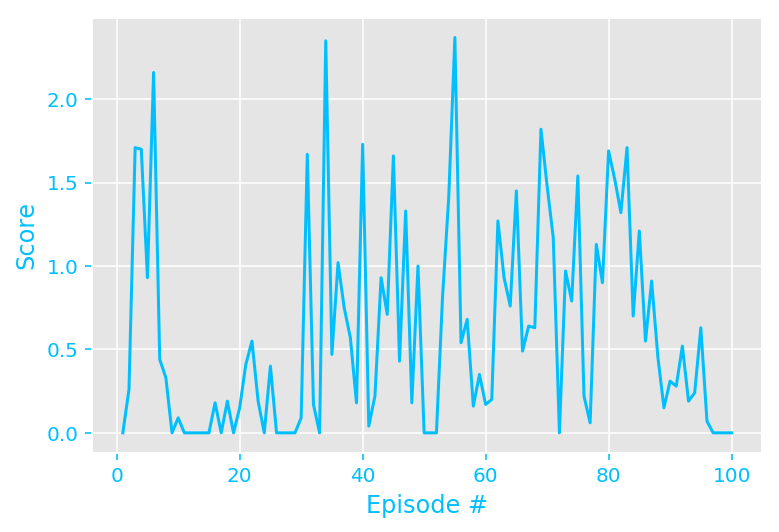



Test try #2 : Smaller sigma for OU Noise process

[INFO]ddpg constructor called with parameters: state_size=33 action_size=4 random_seed=10 actor_fc1_units=400 actor_fc2_units=300 critic_fcs1_units=400 critic_fc2_units=300 buffer_size=100000 batch_size=128 gamma=0.99 tau=0.001 bn_mode=0 lr_actor=0.0001 lr_critic=0.001 weight_decay=0 add_ounoise=True mu=0.0 theta=0.15 sigma=0.1 


Start training:
Episode 100	Average Score: 1.55


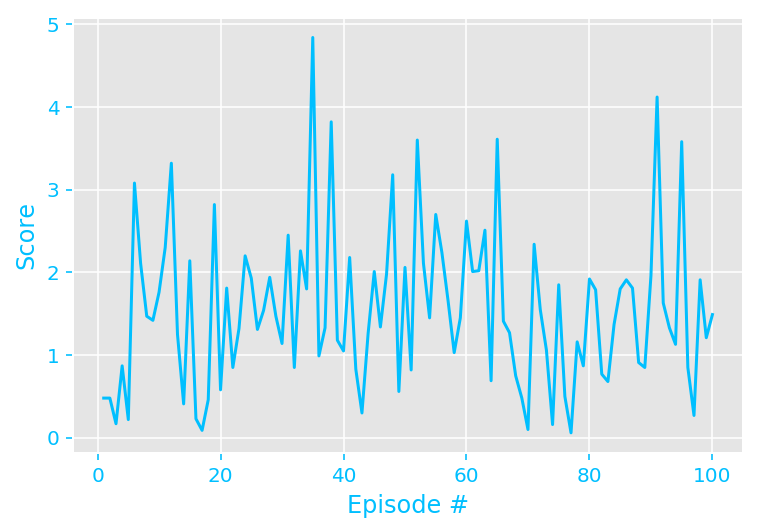



Test try #3 : Use Batch Normization (before activation) in Actor/Critic models + #2

[INFO]ddpg constructor called with parameters: state_size=33 action_size=4 random_seed=10 actor_fc1_units=400 actor_fc2_units=300 critic_fcs1_units=400 critic_fc2_units=300 buffer_size=100000 batch_size=128 gamma=0.99 tau=0.001 bn_mode=1 lr_actor=0.0001 lr_critic=0.001 weight_decay=0 add_ounoise=True mu=0.0 theta=0.15 sigma=0.1 


Start training:
Episode 100	Average Score: 1.81


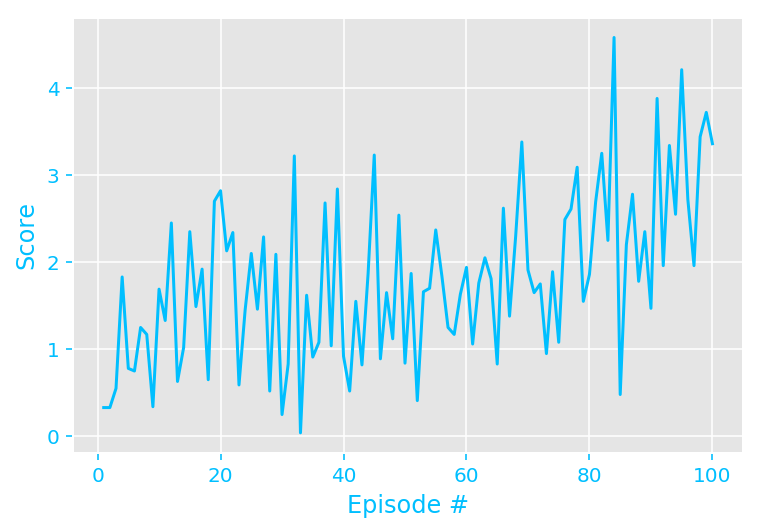



Test try #4 : Use Batch Normization (after activation) in Actor/Critic models + #2

[INFO]ddpg constructor called with parameters: state_size=33 action_size=4 random_seed=10 actor_fc1_units=400 actor_fc2_units=300 critic_fcs1_units=400 critic_fc2_units=300 buffer_size=100000 batch_size=128 gamma=0.99 tau=0.001 bn_mode=2 lr_actor=0.0001 lr_critic=0.001 weight_decay=0 add_ounoise=True mu=0.0 theta=0.15 sigma=0.1 


Start training:
Episode 100	Average Score: 0.89


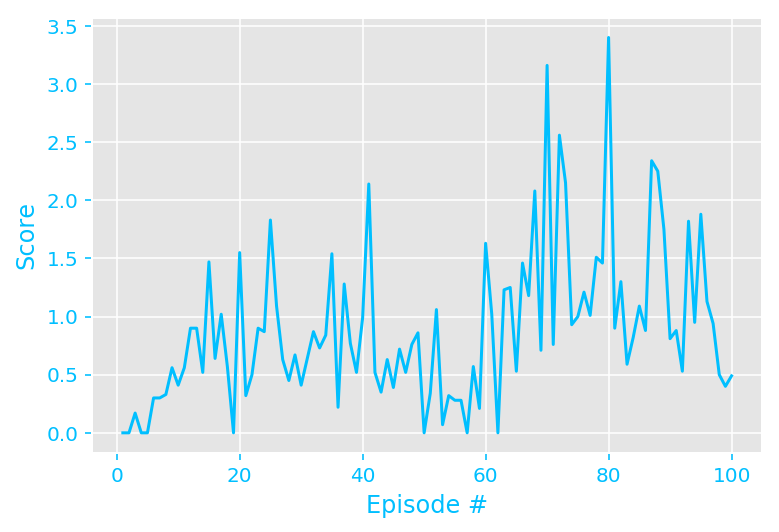



Test try #3bis : Use Batch Normization (after activation) in Actor/Critic models + #2

[INFO]ddpg constructor called with parameters: state_size=33 action_size=4 random_seed=10 actor_fc1_units=400 actor_fc2_units=300 critic_fcs1_units=400 critic_fc2_units=300 buffer_size=100000 batch_size=128 gamma=0.99 tau=0.001 bn_mode=3 lr_actor=0.0001 lr_critic=0.001 weight_decay=0 add_ounoise=True mu=0.0 theta=0.15 sigma=0.1 


Start training:
Episode 100	Average Score: 2.58


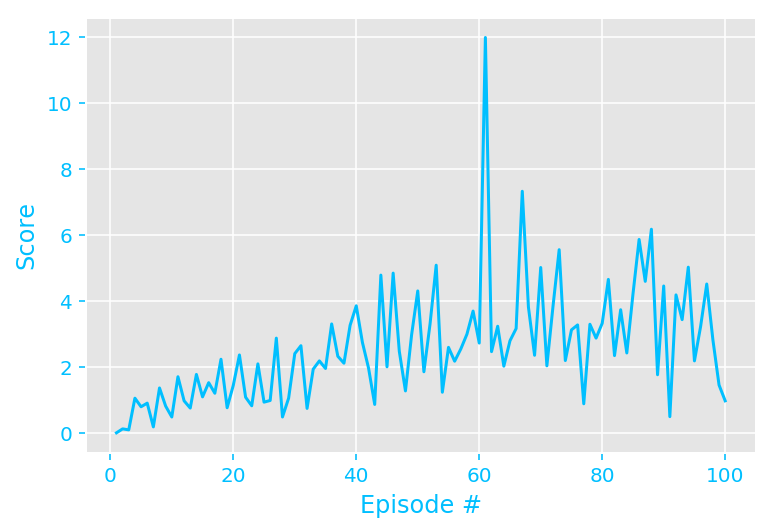



Test try #4bis : Use Batch Normization (after activation) in Actor/Critic models + #2

[INFO]ddpg constructor called with parameters: state_size=33 action_size=4 random_seed=10 actor_fc1_units=400 actor_fc2_units=300 critic_fcs1_units=400 critic_fc2_units=300 buffer_size=100000 batch_size=128 gamma=0.99 tau=0.001 bn_mode=4 lr_actor=0.0001 lr_critic=0.001 weight_decay=0 add_ounoise=True mu=0.0 theta=0.15 sigma=0.1 


Start training:
Episode 100	Average Score: 0.01


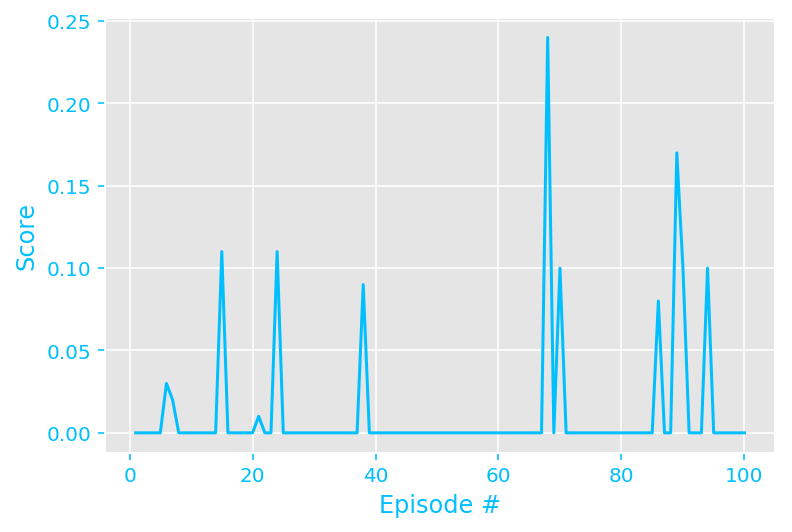



Test try #5 : Small neural networks + #3

[INFO]ddpg constructor called with parameters: state_size=33 action_size=4 random_seed=10 actor_fc1_units=128 actor_fc2_units=128 critic_fcs1_units=128 critic_fc2_units=128 buffer_size=100000 batch_size=128 gamma=0.99 tau=0.001 bn_mode=1 lr_actor=0.0001 lr_critic=0.001 weight_decay=0 add_ounoise=True mu=0.0 theta=0.15 sigma=0.1 


Start training:
Episode 100	Average Score: 1.91


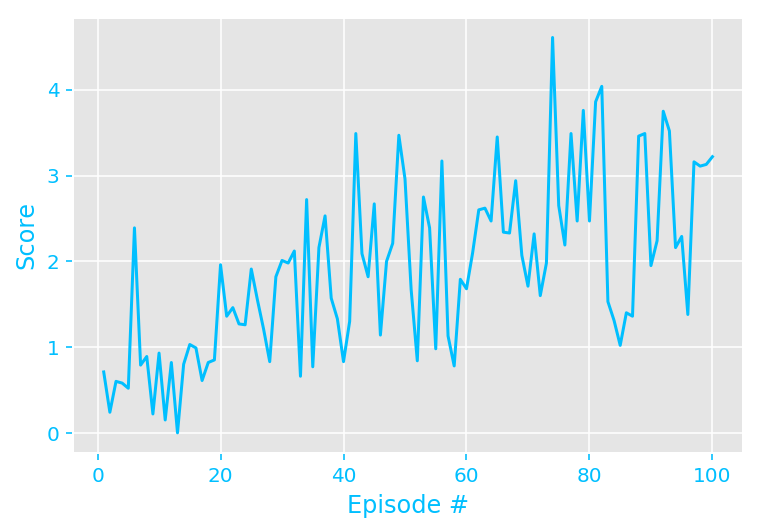



Test try #6 : Small neural networks + #4

[INFO]ddpg constructor called with parameters: state_size=33 action_size=4 random_seed=10 actor_fc1_units=128 actor_fc2_units=128 critic_fcs1_units=128 critic_fc2_units=128 buffer_size=100000 batch_size=128 gamma=0.99 tau=0.001 bn_mode=2 lr_actor=0.0001 lr_critic=0.001 weight_decay=0 add_ounoise=True mu=0.0 theta=0.15 sigma=0.1 


Start training:
Episode 100	Average Score: 2.75


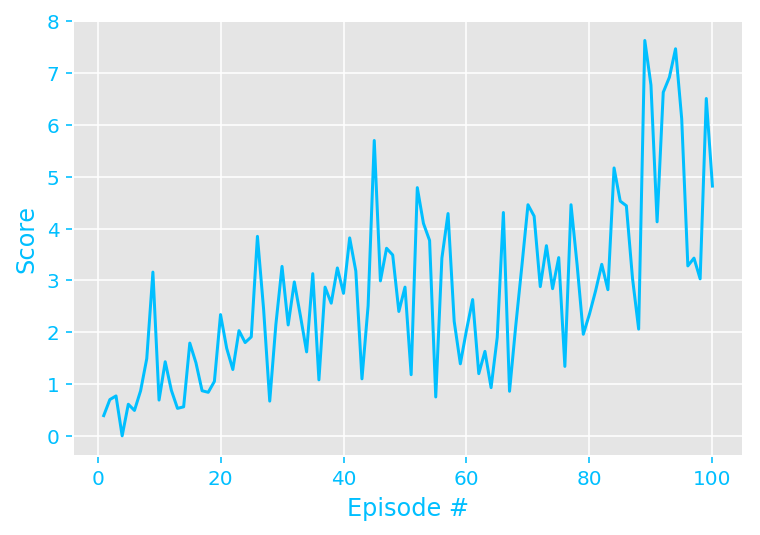



Test try #7 : Faster learning rate for critic + #6

[INFO]ddpg constructor called with parameters: state_size=33 action_size=4 random_seed=10 actor_fc1_units=128 actor_fc2_units=128 critic_fcs1_units=128 critic_fc2_units=128 buffer_size=100000 batch_size=128 gamma=0.99 tau=0.001 bn_mode=2 lr_actor=0.0001 lr_critic=0.0001 weight_decay=0 add_ounoise=True mu=0.0 theta=0.15 sigma=0.1 


Start training:
Episode 100	Average Score: 4.10


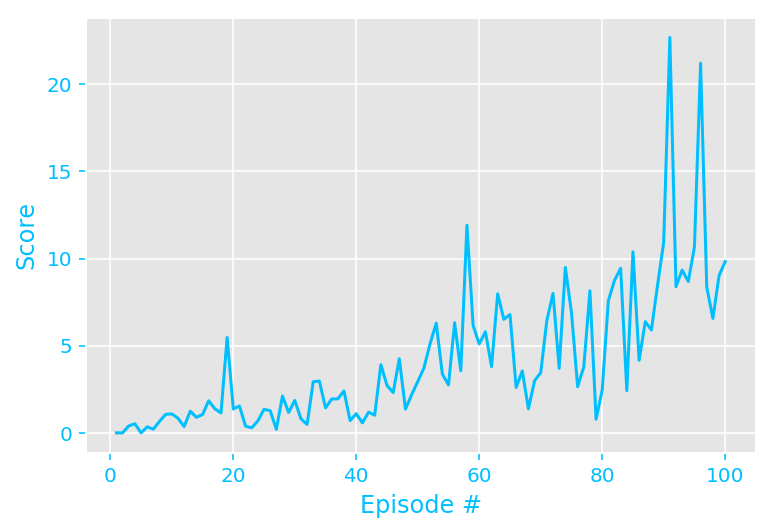



Test try #8 : Faster learning rates  + #6

[INFO]ddpg constructor called with parameters: state_size=33 action_size=4 random_seed=10 actor_fc1_units=128 actor_fc2_units=128 critic_fcs1_units=128 critic_fc2_units=128 buffer_size=100000 batch_size=128 gamma=0.99 tau=0.001 bn_mode=2 lr_actor=0.0002 lr_critic=0.0002 weight_decay=0 add_ounoise=True mu=0.0 theta=0.15 sigma=0.1 


Start training:
Episode 100	Average Score: 3.74


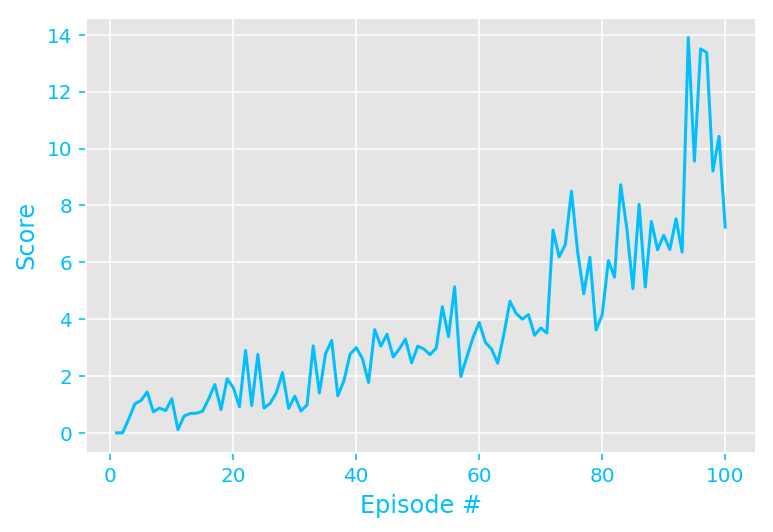



Test try #9 : Even Faster learning rates  + #6

[INFO]ddpg constructor called with parameters: state_size=33 action_size=4 random_seed=10 actor_fc1_units=128 actor_fc2_units=128 critic_fcs1_units=128 critic_fc2_units=128 buffer_size=100000 batch_size=128 gamma=0.99 tau=0.001 bn_mode=2 lr_actor=0.0005 lr_critic=0.0005 weight_decay=0 add_ounoise=True mu=0.0 theta=0.15 sigma=0.1 


Start training:
Episode 100	Average Score: 6.83


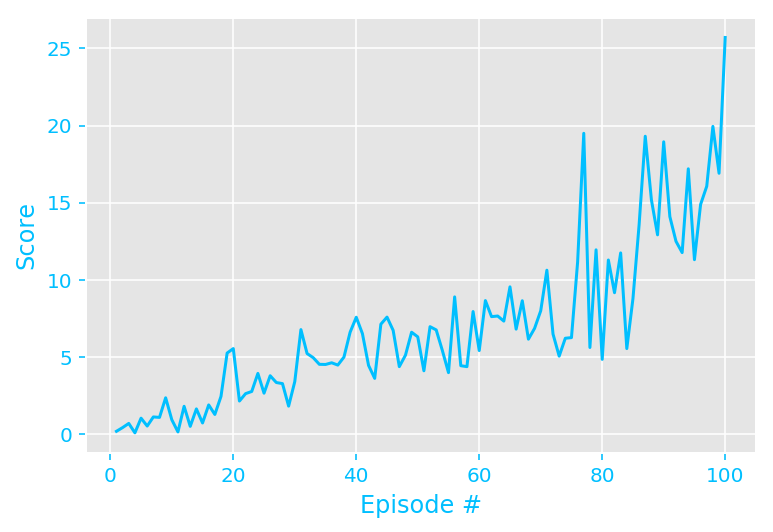



Test try #10 : Even More Faster learning rates  + #6

[INFO]ddpg constructor called with parameters: state_size=33 action_size=4 random_seed=10 actor_fc1_units=128 actor_fc2_units=128 critic_fcs1_units=128 critic_fc2_units=128 buffer_size=100000 batch_size=128 gamma=0.99 tau=0.001 bn_mode=2 lr_actor=0.001 lr_critic=0.001 weight_decay=0 add_ounoise=True mu=0.0 theta=0.15 sigma=0.1 


Start training:
Episode 100	Average Score: 3.93


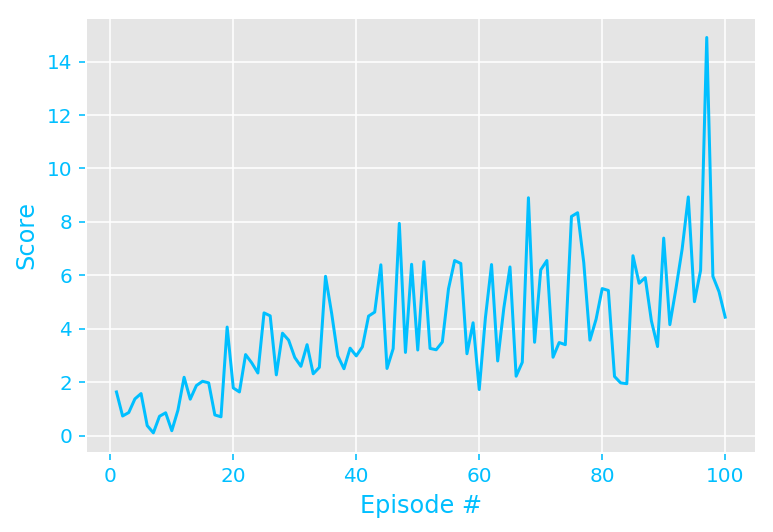



Test try : Agent candidate

[INFO]ddpg constructor called with parameters: state_size=33 action_size=4 random_seed=10 actor_fc1_units=128 actor_fc2_units=128 critic_fcs1_units=128 critic_fc2_units=128 buffer_size=100000 batch_size=128 gamma=0.99 tau=0.001 bn_mode=2 lr_actor=0.0002 lr_critic=0.0002 weight_decay=0.0 add_ounoise=True mu=0.0 theta=0.15 sigma=0.1 


Start training:
Episode 100	Average Score: 4.20


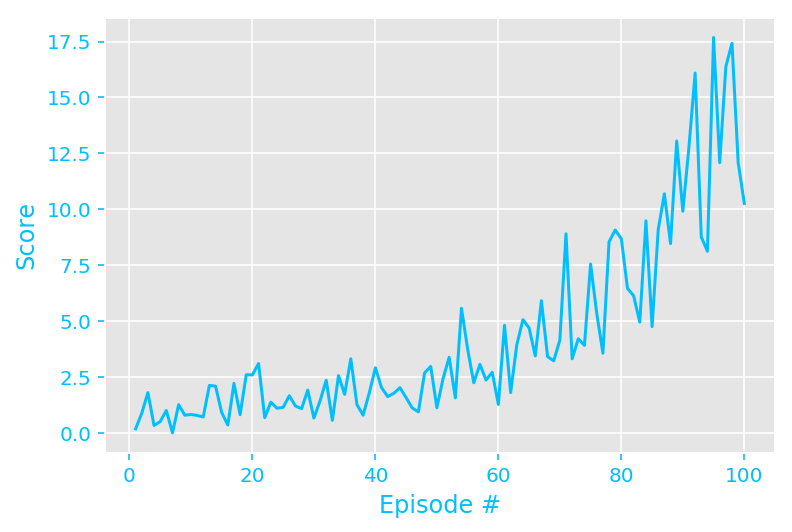

In [6]:
print("Test try #1 : Default Values")
scores = ddpg(n_episodes=100, max_t=1000, 
              actor_fc1_units=ACTOR_FC1_UNITS, actor_fc2_units=ACTOR_FC2_UNITS,
              critic_fcs1_units=CRITIC_FCS1_UNITS, critic_fc2_units=CRITIC_FC2_UNITS, bn_mode=BN_MODE,
              gamma=GAMMA, tau=TAU, lr_actor=LR_ACTOR, lr_critic=LR_CRITIC, weight_decay=WEIGHT_DECAY,
              add_ounoise=ADD_OU_NOISE, mu=MU, theta=THETA, sigma=SIGMA)

plot_training(scores)

print("\n\nTest try #2 : Smaller sigma for OU Noise process")
scores = ddpg(n_episodes=100, max_t=1000, 
              actor_fc1_units=ACTOR_FC1_UNITS, actor_fc2_units=ACTOR_FC2_UNITS,
              critic_fcs1_units=CRITIC_FCS1_UNITS, critic_fc2_units=CRITIC_FC2_UNITS, bn_mode=BN_MODE,
              gamma=GAMMA, tau=TAU, lr_actor=LR_ACTOR, lr_critic=LR_CRITIC, weight_decay=WEIGHT_DECAY,
              add_ounoise=ADD_OU_NOISE, mu=MU, theta=THETA, sigma=0.1)

plot_training(scores)

print("\n\nTest try #3 : Use Batch Normization (before activation) in Actor/Critic models + #2")
scores = ddpg(n_episodes=100, max_t=1000, 
              actor_fc1_units=ACTOR_FC1_UNITS, actor_fc2_units=ACTOR_FC2_UNITS,
              critic_fcs1_units=CRITIC_FCS1_UNITS, critic_fc2_units=CRITIC_FC2_UNITS, bn_mode=1,
              gamma=GAMMA, tau=TAU, lr_actor=LR_ACTOR, lr_critic=LR_CRITIC, weight_decay=WEIGHT_DECAY,
              add_ounoise=ADD_OU_NOISE, mu=MU, theta=THETA, sigma=0.1)

plot_training(scores)

print("\n\nTest try #4 : Use Batch Normization (after activation) in Actor/Critic models + #2")
scores = ddpg(n_episodes=100, max_t=1000, 
              actor_fc1_units=ACTOR_FC1_UNITS, actor_fc2_units=ACTOR_FC2_UNITS,
              critic_fcs1_units=CRITIC_FCS1_UNITS, critic_fc2_units=CRITIC_FC2_UNITS, bn_mode=2,
              gamma=GAMMA, tau=TAU, lr_actor=LR_ACTOR, lr_critic=LR_CRITIC, weight_decay=WEIGHT_DECAY,
              add_ounoise=ADD_OU_NOISE, mu=MU, theta=THETA, sigma=0.1)

plot_training(scores)

print("\n\nTest try #3bis : Use Batch Normization (after activation) in Actor/Critic models + #2")
scores = ddpg(n_episodes=100, max_t=1000, 
              actor_fc1_units=ACTOR_FC1_UNITS, actor_fc2_units=ACTOR_FC2_UNITS,
              critic_fcs1_units=CRITIC_FCS1_UNITS, critic_fc2_units=CRITIC_FC2_UNITS, bn_mode=3,
              gamma=GAMMA, tau=TAU, lr_actor=LR_ACTOR, lr_critic=LR_CRITIC, weight_decay=WEIGHT_DECAY,
              add_ounoise=ADD_OU_NOISE, mu=MU, theta=THETA, sigma=0.1)

plot_training(scores)

print("\n\nTest try #4bis : Use Batch Normization (after activation) in Actor/Critic models + #2")
scores = ddpg(n_episodes=100, max_t=1000, 
              actor_fc1_units=ACTOR_FC1_UNITS, actor_fc2_units=ACTOR_FC2_UNITS,
              critic_fcs1_units=CRITIC_FCS1_UNITS, critic_fc2_units=CRITIC_FC2_UNITS, bn_mode=4,
              gamma=GAMMA, tau=TAU, lr_actor=LR_ACTOR, lr_critic=LR_CRITIC, weight_decay=WEIGHT_DECAY,
              add_ounoise=ADD_OU_NOISE, mu=MU, theta=THETA, sigma=0.1)

plot_training(scores)

print("\n\nTest try #5 : Small neural networks + #3")
scores = ddpg(n_episodes=100, max_t=1000, 
              actor_fc1_units=128, actor_fc2_units=128,
              critic_fcs1_units=128, critic_fc2_units=128, bn_mode=1,
              gamma=GAMMA, tau=TAU, lr_actor=LR_ACTOR, lr_critic=LR_CRITIC, weight_decay=WEIGHT_DECAY,
              add_ounoise=ADD_OU_NOISE, mu=MU, theta=THETA, sigma=0.1)

plot_training(scores)

print("\n\nTest try #6 : Small neural networks + #4")
scores = ddpg(n_episodes=100, max_t=1000, 
              actor_fc1_units=128, actor_fc2_units=128,
              critic_fcs1_units=128, critic_fc2_units=128, bn_mode=2,
              gamma=GAMMA, tau=TAU, lr_actor=LR_ACTOR, lr_critic=LR_CRITIC, weight_decay=WEIGHT_DECAY,
              add_ounoise=ADD_OU_NOISE, mu=MU, theta=THETA, sigma=0.1)

plot_training(scores)

print("\n\nTest try #7 : Faster learning rate for critic + #6")
scores = ddpg(n_episodes=100, max_t=1000, 
              actor_fc1_units=128, actor_fc2_units=128,
              critic_fcs1_units=128, critic_fc2_units=128, bn_mode=2,
              gamma=GAMMA, tau=TAU, lr_actor=1e-4, lr_critic=1e-4, weight_decay=WEIGHT_DECAY,
              add_ounoise=ADD_OU_NOISE, mu=MU, theta=THETA, sigma=0.1)

plot_training(scores)

print("\n\nTest try #8 : Faster learning rates  + #6")
scores = ddpg(n_episodes=100, max_t=1000, 
              actor_fc1_units=128, actor_fc2_units=128,
              critic_fcs1_units=128, critic_fc2_units=128, bn_mode=2,
              gamma=GAMMA, tau=TAU, lr_actor=2e-4, lr_critic=2e-4, weight_decay=WEIGHT_DECAY,
              add_ounoise=ADD_OU_NOISE, mu=MU, theta=THETA, sigma=0.1)

plot_training(scores)

print("\n\nTest try #9 : Even Faster learning rates  + #6")
scores = ddpg(n_episodes=100, max_t=1000, 
              actor_fc1_units=128, actor_fc2_units=128,
              critic_fcs1_units=128, critic_fc2_units=128, bn_mode=2,
              gamma=GAMMA, tau=TAU, lr_actor=5e-4, lr_critic=5e-4, weight_decay=WEIGHT_DECAY,
              add_ounoise=ADD_OU_NOISE, mu=MU, theta=THETA, sigma=0.1)

plot_training(scores)

print("\n\nTest try #10 : Even More Faster learning rates  + #6")
scores = ddpg(n_episodes=100, max_t=1000, 
              actor_fc1_units=128, actor_fc2_units=128,
              critic_fcs1_units=128, critic_fc2_units=128, bn_mode=2,
              gamma=GAMMA, tau=TAU, lr_actor=1e-3, lr_critic=1e-3, weight_decay=WEIGHT_DECAY,
              add_ounoise=ADD_OU_NOISE, mu=MU, theta=THETA, sigma=0.1)

plot_training(scores)

print("\n\nTest try : Agent candidate")
scores = ddpg(n_episodes=100, max_t=1000, 
              actor_fc1_units=128, actor_fc2_units=128,
              critic_fcs1_units=128, critic_fc2_units=128, bn_mode=2,
              gamma=0.99, tau=1e-3, lr_actor=2e-4, lr_critic=2e-4, weight_decay=0.,
              add_ounoise=True, mu=0., theta=0.15, sigma=0.1 )

plot_training(scores)

#### Full Training (Initial version)

Based on the previous results, I choosed to try a full training on the candidate version, but with a slighty increased learning rate.


[INFO]ddpg constructor called with parameters: state_size=33 action_size=4 random_seed=10 actor_fc1_units=128 actor_fc2_units=128 critic_fcs1_units=128 critic_fc2_units=128 buffer_size=100000 batch_size=128 gamma=0.99 tau=0.001 bn_mode=2 lr_actor=0.0005 lr_critic=0.0005 weight_decay=0.0 add_ounoise=True mu=0.0 theta=0.15 sigma=0.1 


Start training:
Episode 100	Average Score: 6.43
Episode 200	Average Score: 25.28
Environment solved in 300 episodes with an Average Score of 30.01


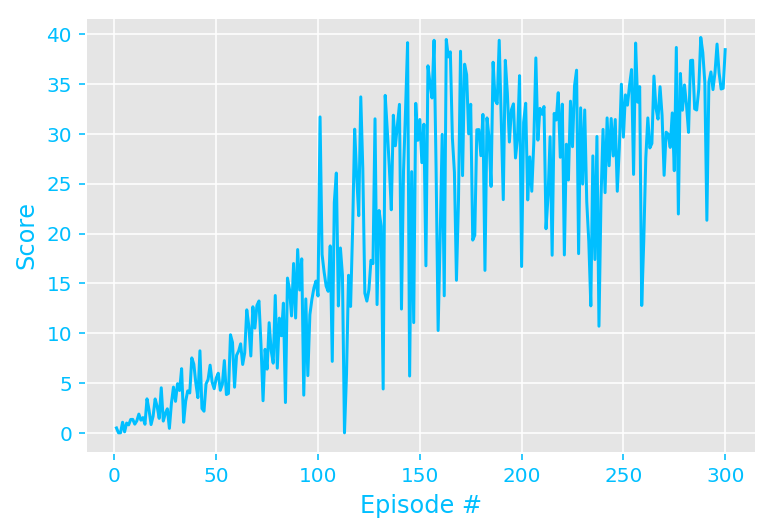

In [7]:
scores = ddpg(n_episodes=1500, max_t=1000, 
              actor_fc1_units=128, actor_fc2_units=128,
              critic_fcs1_units=128, critic_fc2_units=128, bn_mode=2,
              gamma=0.99, tau=1e-3, lr_actor=5e-4, lr_critic=5e-4, weight_decay=0.,
              add_ounoise=True, mu=0., theta=0.15, sigma=0.1 )

plot_training(scores)

#### Full Training (Final version)

While the environment can be solved with the previous configuration, the learning can be slightly enhanced by dimming a bit the learning rates used.


[INFO]ddpg constructor called with parameters: state_size=33 action_size=4 random_seed=10 actor_fc1_units=128 actor_fc2_units=128 critic_fcs1_units=128 critic_fc2_units=128 buffer_size=100000 batch_size=128 gamma=0.99 tau=0.001 bn_mode=2 lr_actor=0.0002 lr_critic=0.0002 weight_decay=0.0 add_ounoise=True mu=0.0 theta=0.15 sigma=0.1 


Start training:
Episode 100	Average Score: 4.38
Episode 200	Average Score: 26.83
Environment solved in 300 episodes with an Average Score of 34.37


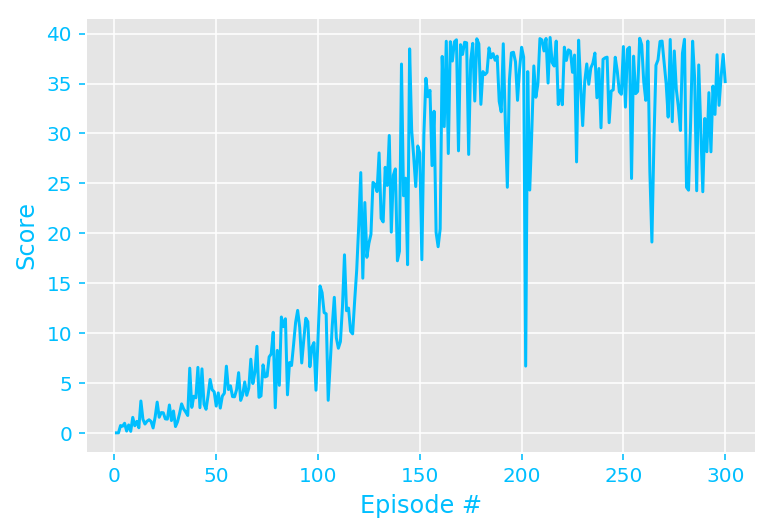

In [8]:
scores = ddpg(n_episodes=1500, max_t=1000, 
              actor_fc1_units=128, actor_fc2_units=128,
              critic_fcs1_units=128, critic_fc2_units=128, bn_mode=2,
              gamma=0.99, tau=1e-3, lr_actor=2e-4, lr_critic=2e-4, weight_decay=0.,
              add_ounoise=True, mu=0., theta=0.15, sigma=0.1 )

plot_training(scores)

In [9]:
env.close()